In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import numpy as np
import os

In [2]:
plt.rc('legend', fontsize=9)
#plt.rc('text', usetex=True)

In [3]:
# Load data files and extract spike train for each current step
# /separate runs/*.dat (NeuroML2)
dt = 0.001
ms_to_index = lambda ms: int(ms / dt)
index_to_ms = lambda ind: ind * dt
threshold = -0.025

dat_files = [f for f in os.listdir('separate runs') if os.path.isfile(os.path.join('separate runs', f)) and os.path.splitext(f)[1] == '.dat']
currents = np.array([float(f[:-6]) for f in dat_files])  # pA
spike_trains = []
for f in dat_files:
    t, v, i = np.genfromtxt(os.path.join('separate runs', f)).transpose()
    spike_trains.append(v)

In [5]:
# Extract spike times via voltage threshold
spike_times = []
for spike_train in spike_trains:
    current_spike_times = []
    for i in range(spike_train.size-1):
        if spike_train[i] < threshold and spike_train[i+1] >= threshold:
            current_spike_times.append(index_to_ms(i))
    spike_times.append(np.array(current_spike_times))
#spike_times

In [8]:
# Delays to first spike
delays = [times[0] - 10 if len(t) > 0 else np.nan for times in spike_times]  # current pulse starts at 10 ms
#delays

In [40]:
fit_delays = np.poly1d(np.polyfit(currents+12, delays, 3))

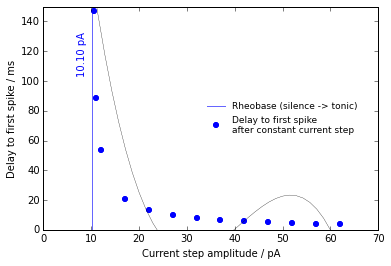

In [41]:
plt.errorbar(currents+12, delays, fmt='o', capsize=7, markeredgecolor='none', label='Delay to first spike\nafter constant current step')  #yerr=0.001,
plt.xlim(0, 70)
plt.ylim(0, 150)
plt.xlabel('Current step amplitude / pA')
plt.ylabel('Delay to first spike / ms')
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, 128, '10.10 pA', color='b', rotation=90)
plt.legend(loc='center right', numpoints=1, borderaxespad=2, frameon=False)

x = np.linspace(0, 70)
plt.plot(x, fit_delays(x), 'black', linewidth=0.3)

plt.savefig("delay.png", dpi=300)

In [27]:
# Minima, maxima and amplitudes (maxima - minima) of membrane voltage during spikes
minima = []
maxima = []
amplitudes = []
for spike_train, times in zip(spike_trains, spike_times):
    current_minima = []
    current_maxima = []
    current_amplitudes = []
    for i in range(len(times)-1):
        start = ms_to_index(times[i])
        end = ms_to_index(times[i+1])
        minimum = np.min(spike_train[start:end] * 1000)  # mV
        maximum = np.max(spike_train[start:end] * 1000)  # mV
        current_minima.append(maximum)
        current_maxima.append(minimum)
        current_amplitudes.append(maximum - minimum)
    minima.append(np.array(current_minima))
    maxima.append(np.array(current_maxima))
    amplitudes.append(np.array(current_amplitudes))
#zip(minima, maxima, amplitudes)

In [28]:
mean_minima = map(np.mean, [x[2:-1] for x in minima])  # exclude first two spikes and last spike to eliminate effects at the start and end of the current step
sem_minima = map(sp.stats.sem, [x[2:-1] for x in minima])
mean_maxima = map(np.mean, [x[2:-1] for x in maxima])
sem_maxima = map(sp.stats.sem, [x[2:-1] for x in maxima])
mean_amplitudes = map(np.mean, [x[2:-1] for x in amplitudes])
sem_amplitudes = map(sp.stats.sem, [x[2:-1] for x in amplitudes])

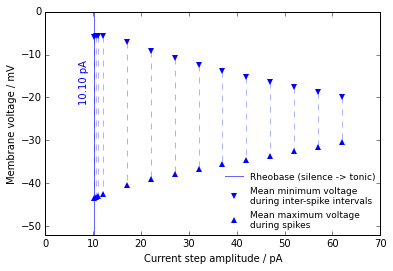

In [29]:
plt.errorbar(currents+12, mean_minima, fmt='v', color='b', capsize=7, markeredgecolor='none', label='Mean minimum voltage\nduring inter-spike intervals')  # yerr=sem_minima
plt.errorbar(currents+12, mean_maxima, fmt='^', color='b', capsize=7, markeredgecolor='none', label='Mean maximum voltage\nduring spikes')  # yerr=sem_maxima

plt.vlines(currents+12, mean_minima, mean_maxima, alpha=0.3, color='b', linestyle='--')

plt.xlabel('Current step amplitude / pA')
plt.ylabel('Membrane voltage / mV')
plt.xlim(0, 70)
plt.ylim(-52, 0)
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, -13, '10.10 pA', color='b', rotation=90)
plt.legend(loc='lower right', numpoints=1, borderaxespad=0.2, frameon=False)
plt.savefig("min_max.png", dpi=300)

In [36]:
fit_amplitudes = np.poly1d(np.polyfit(currents+12, mean_amplitudes, 1))

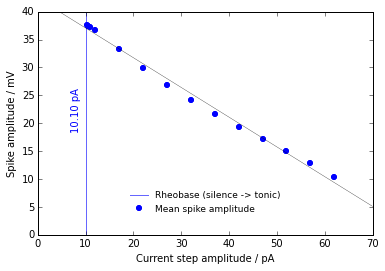

In [37]:
plt.errorbar(currents+12, mean_amplitudes, fmt='o', capsize=7, markeredgecolor='none', label='Mean spike amplitude')  # yerr=sem_amplitudes
plt.xlabel('Current step amplitude / pA')
plt.ylabel('Spike amplitude / mV')
plt.xlim(0, 70)
plt.ylim(0, 40)
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, 25, '10.10 pA', color='b', rotation=90)
plt.legend(loc='lower center', numpoints=1, borderaxespad=2, frameon=False)

x = np.linspace(1, 70)
plt.plot(x, fit_amplitudes(x), 'black', linewidth=0.3)

plt.savefig("amplitudes.png", dpi=300)

In [12]:
first_amplitudes = [x[0] for x in amplitudes]
first_amplitudes_normalized = np.array(first_amplitudes) / np.array(mean_amplitudes)
first_amplitudes_normalized

array([ 1.00334354,  1.00158416,  1.0076681 ,  1.0206119 ,  1.26633451,
        1.42069175,  1.59020838,  1.77884458,  1.99501884,  2.25362674,
        2.58211699,  3.03758359,  3.76735248,  1.12822825])

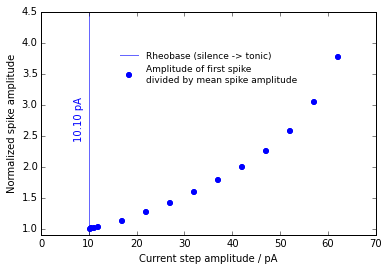

In [13]:
plt.errorbar(currents+12, first_amplitudes_normalized, fmt='o', capsize=7, markeredgecolor='none', label='Amplitude of first spike\ndivided by mean spike amplitude')

plt.xlabel('Current step amplitude / pA')
plt.ylabel('Normalized spike amplitude')
plt.xlim(0, 70)
plt.ylim(0.9, 4.5)
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, 3, '10.10 pA', color='b', rotation=90)
plt.legend(loc='upper center', numpoints=1, borderaxespad=4, frameon=False)

plt.savefig("first_amplitudes.png", dpi=300)